# Transports Through Straits

Computing the depth-integrated volume transport through some major straits.

## Theory

Formally, mass transports are given by

$$T_x = \rho u  $$
$$T_y = \rho v  $$

Mass transports are diagnostics that are calculated online by the model:

| variable|long name|units|dimensions|
| --- |  --- | --- | --- |
| `tx_trans` |T-cell i-mass transport|kg s⁻¹|(time, st_ocean, xu_ocean, yt_ocean)|
| `ty_trans` |T-cell j-mass transport|kg s⁻¹|(time, st_ocean, xt_ocean, yu_ocean)|


Variable `tx_trans` contains the instantaneous zonal transport multiplied with $y$-$z$ face of the volume of each cell:
    <center> `tx_trans`$=T_{x}(x, y, z, t)\,\Delta y\,\Delta z$.</center>

Similarly, `ty_trans` contains
    <center> `ty_trans`$=T_{y}(x, y, z, t)\,\Delta x\,\Delta z$.</center>
    
Thus, `tx_trans` and `ty_trans` variables come in units of $\underbrace{\mathrm{kg}\,\mathrm{m}^{-3}}_{\rm density} \times \underbrace{\mathrm{m}\,\mathrm{s}^{-1}}_{\rm velocity}\times\underbrace{\mathrm{m}^2}_{\rm area} = \mathrm{kg}\,\mathrm{s}^{-1}$.

To get the volume transport ($\mathrm{m}^3\,\mathrm{s}^{-1}$) we have to divide by density $\rho$.

## Calculation

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import numpy as np
import intake
catalog = intake.cat.access_nri
import cf_xarray as cfxr
import pint_xarray
from pint import application_registry as ureg
import cf_xarray.units
import matplotlib.pyplot as plt
from dask.distributed import Client
import logging

Load a `dask` client.

In [2]:
client = Client("tcp://10.6.43.39:8786")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46485,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:38271,Total threads: 4
Dashboard: /proxy/45007/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:43533,


Use default database for this calculation

This dictionary defines a few key choke points that you might be interested in. For the purposes of demonstration we are just using Drake Passage in this example.

In [4]:
straits = {'Drake Passage': [ -69.9,      -69.9,     -71.6, -51.0],
           'Lombok':        [-244.6+360, -243.9+360,  -8.6,  -8.6],
           'Ombai' :        [-235.0+360, -235.0+360,  -9.2,  -8.1],
           'Timor' :        [-235.9+360, -235.9+360, -11.9,  -9.9],
           'Denmark' :      [-42,               -22,  65.8,  65.8],
           'Bering' :       [-172,             -167,  65.8,  65.8],
            }

Here we define a function so that you can specify a given strait, and rely on the function to extract the transport through that strait.

The `calc_transport` will load 18 years of data by default but you can change that by providing different `start_time` and `end_time` keyword arguments, which are then passed onto `cc.querying.getvar`.

In [5]:
ρ0 = 1036 * ureg.kilogram / ureg.meter**3

def calc_transport(experiment, strait, start_time='2000-1-1', end_time='2018-1-1'):
    """
    Calculate barotropic transport across a given 
    line of latitude or longitude.
     
    Designed for flow through straits.
    """
    
    xmin, xmax, ymin, ymax = straits[strait]
    
    if ymax >= 65:
        logging.warning('North of 65N the tripolar grid geometry brings complications and `.sum(''xt_ocean'')` is wrong!')
    
    print('Calculating {}: {} transport'.format(experiment, strait))
    
    if xmin == xmax:                
        cat_subset = catalog[experiment]
        var_search = cat_subset.search(variable='tx_trans')
        darray = var_search.to_dask()
        darray = darray['tx_trans']
        darray = darray.sel(time=slice(start_time, end_time))
        tx_trans = darray
        tx_trans = tx_trans.pint.quantify()

        transport = (tx_trans / ρ0).sel(time=slice(start_time, end_time))\
                                   .sel(xu_ocean=xmin, method='nearest')\
                                   .sel(yt_ocean=slice(ymin, ymax))\
                                   .sum('st_ocean').sum('yt_ocean')
        transport.attrs['long_name'] = 'zonal transport'

    elif ymin == ymax:
        cat_subset = catalog[experiment]
        var_search = cat_subset.search(variable='ty_trans')
        darray = var_search.to_dask()
        darray = darray['ty_trans']
        darray = darray.sel(time=slice(start_time, end_time))
        ty_trans = darray
        ty_trans = ty_trans.pint.quantify()
        
        transport = (ty_trans / ρ0).sel(time=slice(start_time, end_time))\
                                   .sel(yu_ocean=ymin, method='nearest')\
                                   .sel(xt_ocean=slice(xmin, xmax))\
                                   .sum('st_ocean').sum('xt_ocean')
        transport.attrs['long_name'] = 'meridional transport'
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or constant longitude')
    
    transport = transport.pint.to('sverdrup')
    transport = transport.compute()
       
    return transport

Now, for a given experiment, calculate the total (barotropic) transport through Drake Passage:

Calculating 025deg_jra55_iaf_omip2_cycle6: Drake Passage transport
CPU times: user 13.4 s, sys: 1.63 s, total: 15 s
Wall time: 36.4 s


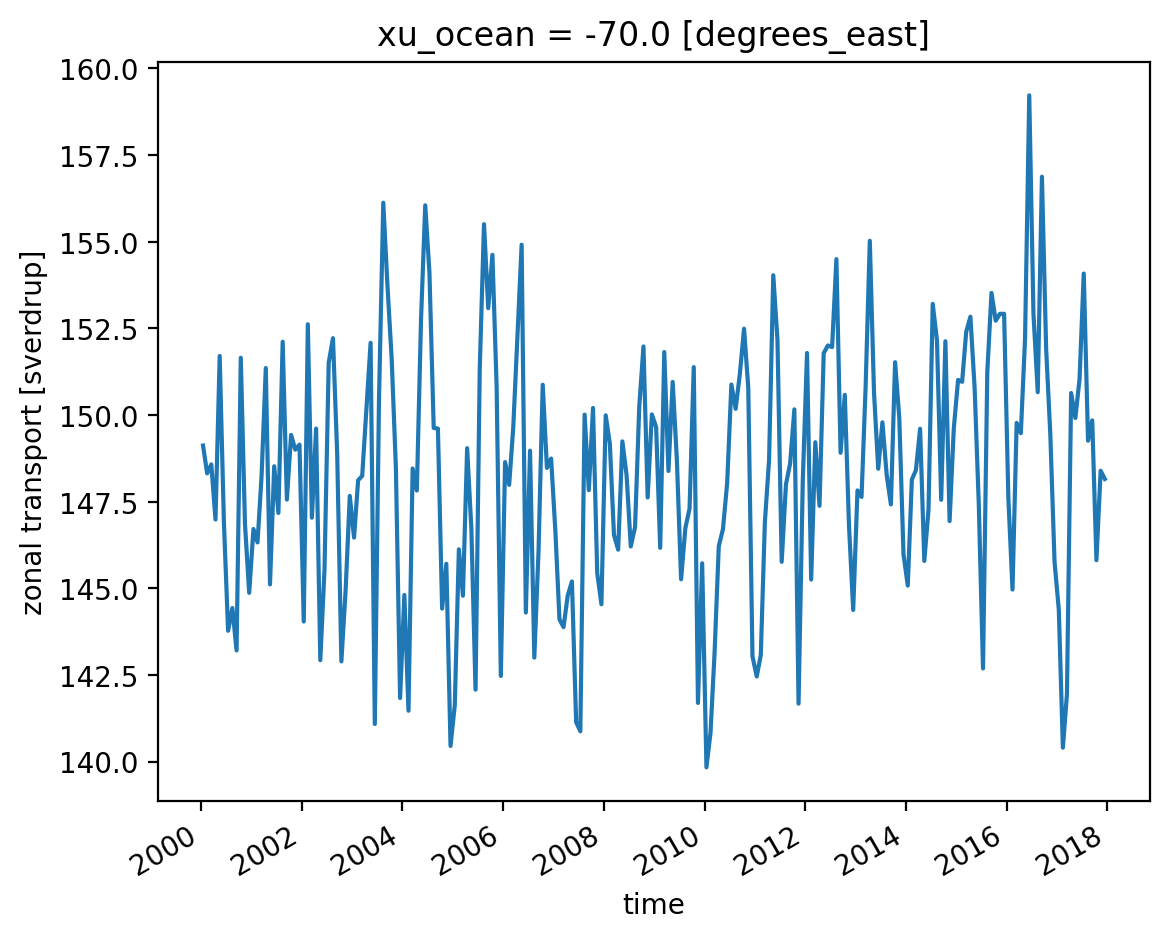

In [6]:
%%time

experiment = '025deg_jra55_iaf_omip2_cycle6'
transport = calc_transport(experiment, 'Drake Passage')
transport.plot();

Or let's just plot all of the straits!

Care must be taken north of 65N when performing zonal averages. Some warnings will be given to remind you that zonal averages north of 65N are not completely correct!

Calculating 025deg_jra55_iaf_omip2_cycle6: Drake Passage transport
Calculating 025deg_jra55_iaf_omip2_cycle6: Lombok transport
Calculating 025deg_jra55_iaf_omip2_cycle6: Ombai transport
Calculating 025deg_jra55_iaf_omip2_cycle6: Timor transport


Calculating 025deg_jra55_iaf_omip2_cycle6: Denmark transport


Calculating 025deg_jra55_iaf_omip2_cycle6: Bering transport


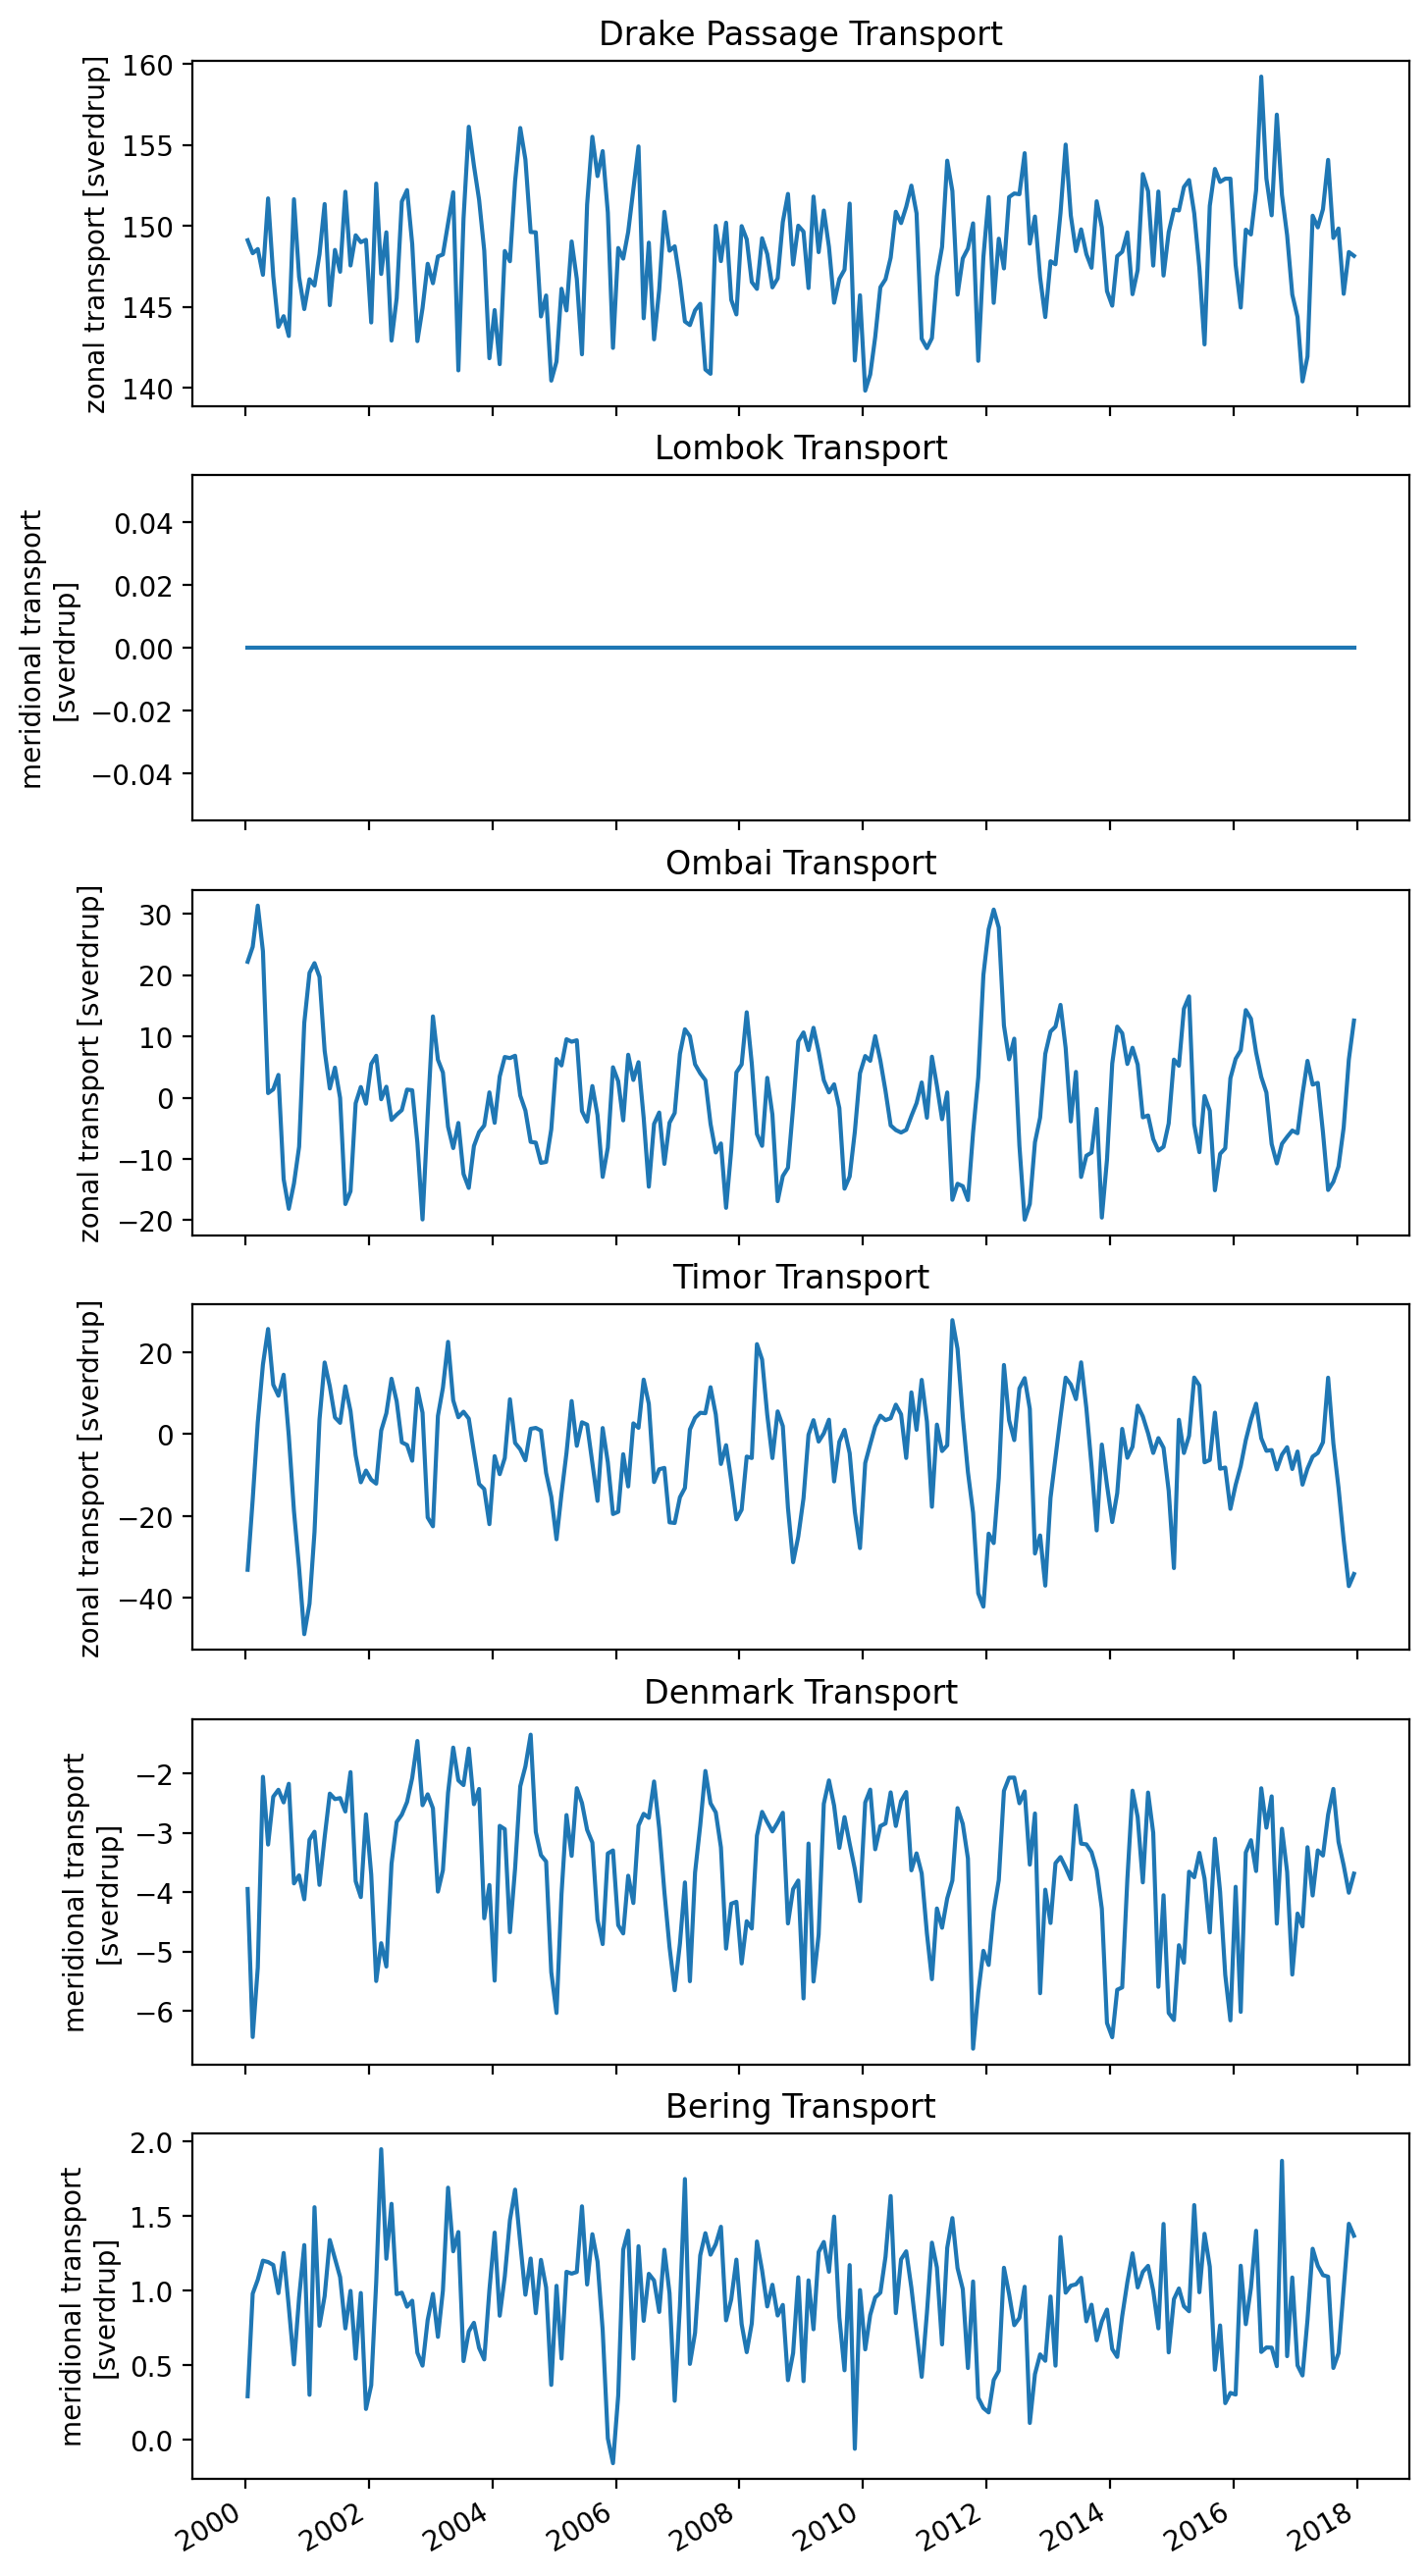

In [7]:
fig, axes = plt.subplots(nrows=6, sharex=True, figsize=(8, 16))

for j, strait in enumerate(straits):
    transport = calc_transport(experiment, strait)
    
    transport.plot(ax=axes[j])
    axes[j].set_xlabel('')
    axes[j].set_title(strait+' Transport');